# Basic usage of SLAT
In this vignette, we show how to use `SLAT` to align spatial datasets.

(You can run this demo in your laptop with >= 8GB memory in 50-100 scends, use GPU can be faster)

In [19]:
# %matplotlib ipympl  # use this if you want to use interactive plot (only works in Jupyter)
import scanpy as sc
import numpy as np
import pandas as pd

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT, spatial_match
from scSLAT.viz import match_3D_multi, hist, Sankey
from scSLAT.metrics import region_statistics

In [20]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14)

## Build datasets
Here, we sample 6000 cells(sample 1) and 5000 cells(sample 2) from two E15.5 mouse embryo dataset respectively.

In [21]:
adata_raw1 = sc.read('../../data/stereo_seq/counts/E15.5/count_E15.5_E1S1_filter_labeled.h5ad')
adata_raw2 = sc.read('../../data/stereo_seq/counts/E15.5/count_E15.5_E1S2_filter_labeled.h5ad')

In [22]:
adata1 = sc.pp.subsample(adata_raw1, n_obs=6000, copy=True)
adata2 = sc.pp.subsample(adata_raw2, n_obs=5000, copy=True)
del adata_raw1, adata_raw2

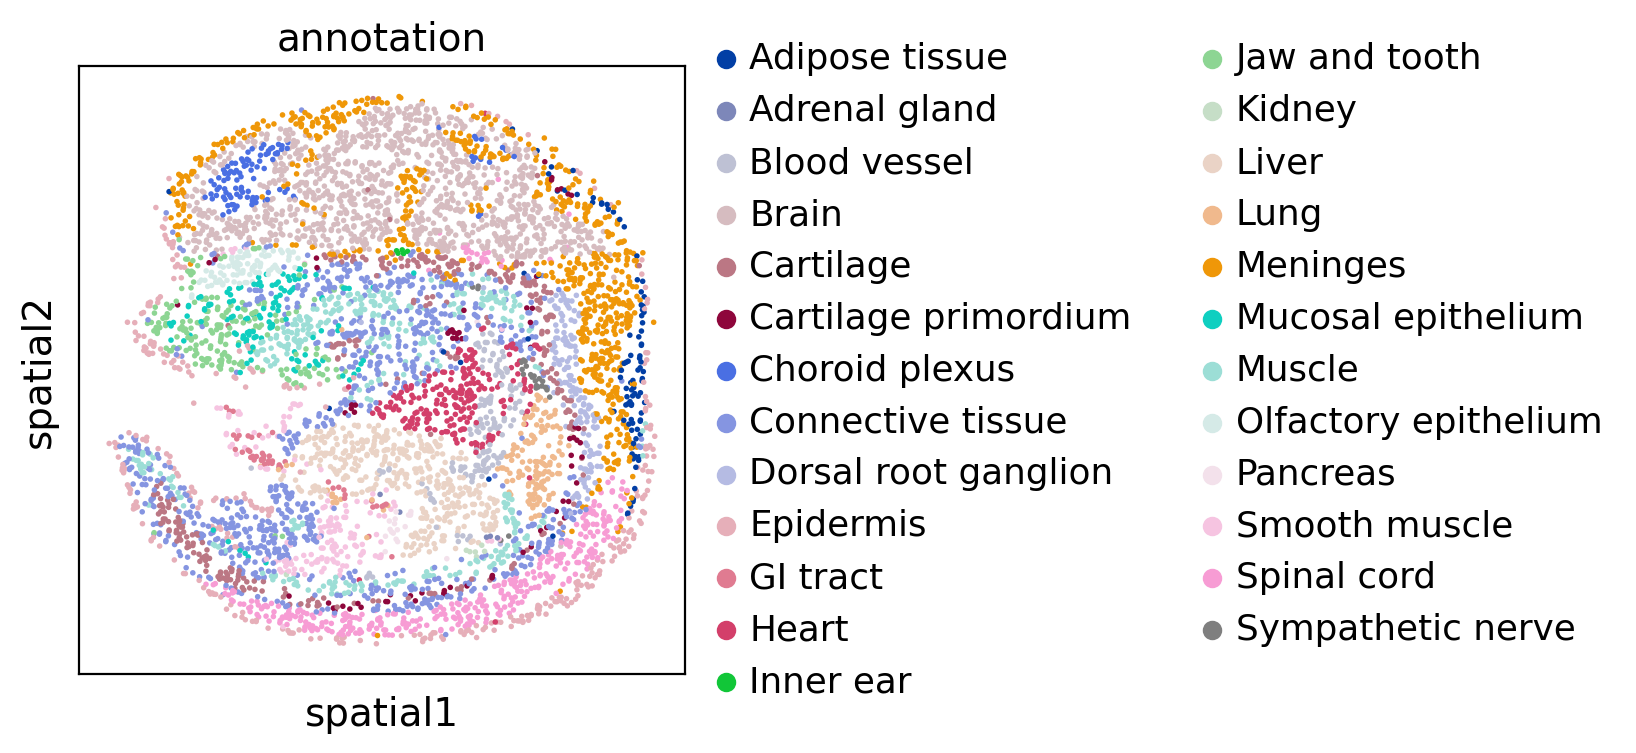

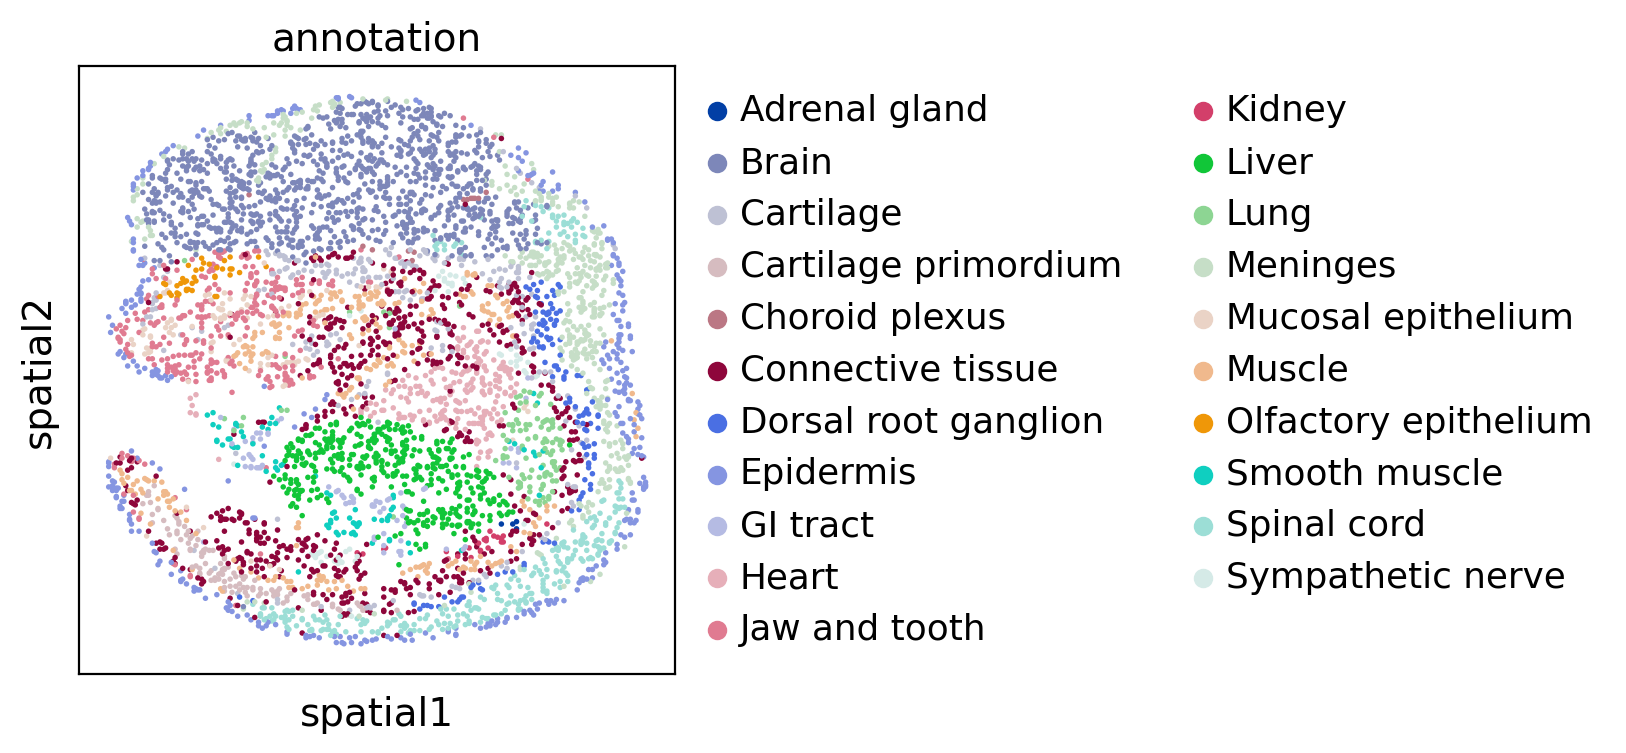

In [23]:
sc.pl.spatial(adata1, color="annotation", spot_size=10)
sc.pl.spatial(adata2, color="annotation", spot_size=10)

## Run SLAT
First, SLAT need build cell graphs based on cell-cell distance in spatial dataset

In [24]:
Cal_Spatial_Net(adata1, k_cutoff=10, model='KNN')
Cal_Spatial_Net(adata2, k_cutoff=10, model='KNN')

Calculating spatial neighbor graph ...
The graph contains 68008 edges, 6000 cells.
11.334666666666667 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 56646 edges, 5000 cells.
11.3292 neighbors per cell on average.


Then, SLAT extract cell gene expression features by DPCA (which is a SVD-based matrix factorization algorithm), and extract cell position features based on graph we built on previous step
> NOTE: SLAT support three built-in embedding algorithms (`DPCA`, `Harmony`, and `PCA`) currently. But you can use any embedding method manually.

In [25]:
edges, features = load_anndatas([adata1, adata2], feature='DPCA')

Use DPCA feature to format graph


/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning:

X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.

/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning:

Received a view of an AnnData. Making a copy.

/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning:

Received a view of an AnnData. Making a copy.

/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning:

Received a view of an AnnData. Making a copy.



Warning! Dual PCA is using GPU, which may lead to OUT OF GPU MEMORY in big dataset!


Then we train SLAT model, it's very fast and finish in 10s.
> Warning: SLAT default hyperparameter can handle most situation. You should not change them unless you know details very well.

In [26]:
embd0, embd1, time = run_SLAT(features, edges)

Choose GPU:1 as device
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 1.74


## Calculate metrics and visualization 
First, we check the confidence of the integrated results, > 0.90 means high confidence level.

If the confidence of most matches is less than 0.9. It suggests that the heterogeneity of the two slices is very high

In [27]:
best, index, distance = spatial_match(features, adatas=[adata1,adata2], reorder=False)

In [28]:
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata1.obsm['spatial'][:,0],
                        'y': adata1.obsm['spatial'][:,1],
                        'celltype': adata1.obs['annotation']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata2.obsm['spatial'][:,0],
                        'y': adata2.obsm['spatial'][:,1],
                        'celltype': adata2.obs['annotation']})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]
region_statistics(best_match, start=0.5, number_of_interval=10)

0.500~0.550        39          0.780%
0.550~0.600       116          2.320%
0.600~0.650       302          6.040%
0.650~0.700       472          9.440%
0.700~0.750       609         12.180%
0.750~0.800       631         12.620%
0.800~0.850       629         12.580%
0.850~0.900       816         16.320%
0.900~0.950      1007         20.140%
0.950~1.000       375          7.500%


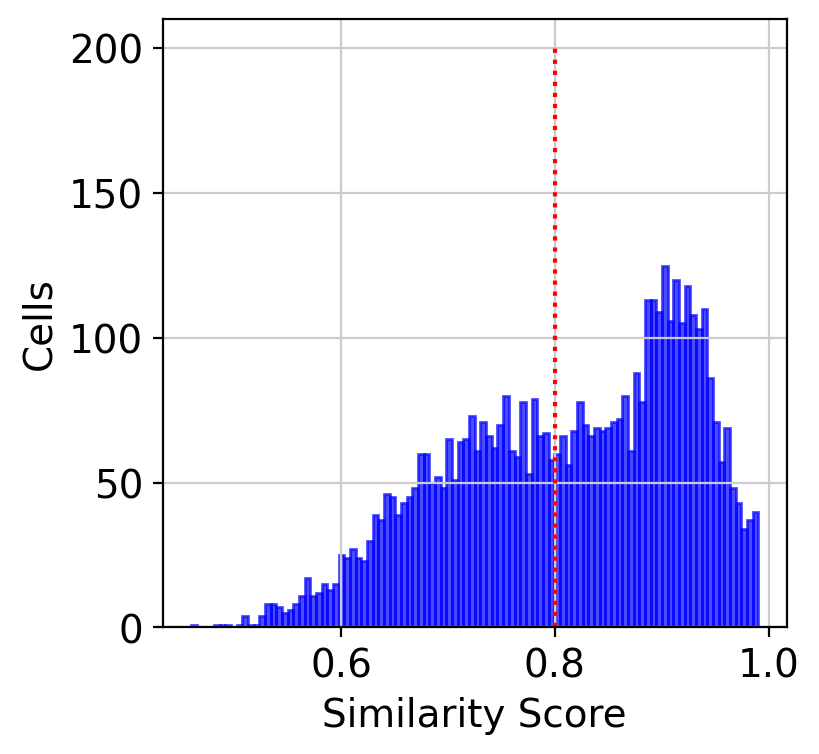

In [29]:
hist(best_match, cut=0.8)

Then we can visualize the cell to cell matching, color means cell type. By default, Blue line means correct match of cell type, red line is the opposite.

dataset1: 25 cell types; dataset2: 21 cell types; 
                    Total :25 celltypes; Overlap: 21 cell types 
                    Not overlap :[['Inner ear', 'Pancreas', 'Adipose tissue', 'Blood vessel']]
Subsample 300 cell pairs from 5000


/rd2/user/xiacr/SLAT/scSLAT/viz/multi_dataset.py:242: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



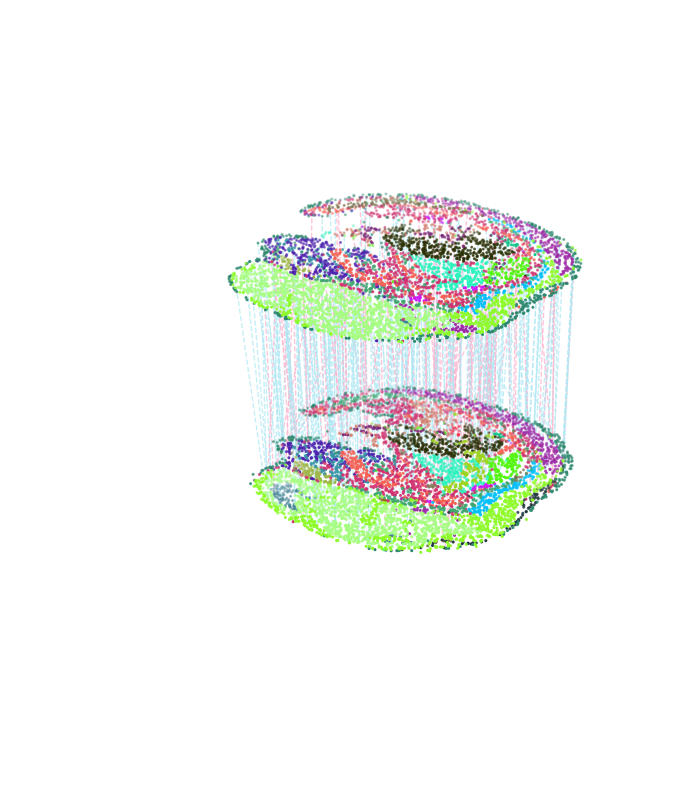

In [30]:
%matplotlib widget 
multi_align = match_3D_multi(adata1_df, adata2_df, matching,meta='celltype',
                            scale_coordinate=True, subsample_size=300)
multi_align.draw_3D(size=[7, 8], line_width=1, point_size=[1.5,1.5], hide_axis=True)
%matplotlib inline

## Similarity score
**Similarity score** means the confident of `SLAT` alignment. Regions with low similarity scores may 1) have biological difference; 2)cause by technology.

In [31]:
adata2.obs['low_quality_index'] = best_match 
adata2.obs['low_quality_index'] = adata2.obs['low_quality_index'].astype(float)

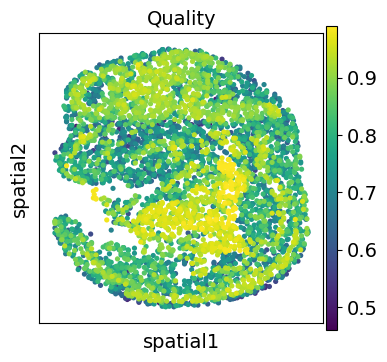

In [32]:
sc.pl.spatial(adata2, color='low_quality_index', spot_size=20, title='Quality')

## Cell type level analysis 
We can check the cell type level corresponding via Sankey diagram.

In [33]:
adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()
matching_table = adata2_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

In [34]:
Sankey(matching_table, prefix=['E15.5_E1S1','E15.5_E1S2'])